## Time Series - Manhattan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
# Import the autocorrelation function (ACF) plot.
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.api import VAR

In [2]:
taxi_manhattan = pd.read_csv('./data/manhattan_full.csv')

In [4]:
taxi_manhattan.head(2)

,Unnamed: 0,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_day_of_week,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,trip_time,pickup_borough,dropoff_borough,zone,pickup_datetime
0,2020-01-01 00:00:00,2.0,2020-01-01 02:02:39,5.0,2.33,1.0,N,186,79,2.0,...,Wednesday,0,2,Late night,Late night,0 days 02:02:39,Manhattan,Manhattan,Penn Station/Madison Sq West,NaN
1,2020-01-01 00:00:00,2.0,2020-01-01 01:45:06,5.0,1.35,1.0,N,48,68,2.0,...,Wednesday,0,1,Late night,Late night,0 days 01:45:06,Manhattan,Manhattan,Clinton East,NaN


In [6]:
taxi_manhattan['pickup_datetime'] = taxi_manhattan['Unnamed: 0']

In [12]:
taxi_manhattan['pickup_datetime'] = pd.to_datetime(taxi_manhattan['pickup_datetime'])


ParserError: day is out of range for month: 0

In [8]:
taxi_manhattan = taxi_manhattan.drop(columns='Unnamed: 0')

In [9]:
taxi_manhattan.head(2)

,VendorID,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,...,dropoff_day_of_week,pickup_hour,dropoff_hour,pickup_timeofday,dropoff_timeofday,trip_time,pickup_borough,dropoff_borough,zone,pickup_datetime
0,2.0,2020-01-01 02:02:39,5.0,2.33,1.0,N,186,79,2.0,11.5,...,Wednesday,0,2,Late night,Late night,0 days 02:02:39,Manhattan,Manhattan,Penn Station/Madison Sq West,2020-01-01 00:00:00
1,2.0,2020-01-01 01:45:06,5.0,1.35,1.0,N,48,68,2.0,8.5,...,Wednesday,0,1,Late night,Late night,0 days 01:45:06,Manhattan,Manhattan,Clinton East,2020-01-01 00:00:00


In [10]:
taxi_manhattan.dtypes

VendorID                 float64
dropoff_datetime          object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
month                     object
year                       int64
pickup_day_of_week        object
dropoff_day_of_week       object
pickup_hour                int64
dropoff_hour               int64
pickup_timeofday          object
dropoff_timeofday         object
trip_time                 object
pickup_borough            object
dropoff_borough           object
zone                      object
pickup_datetime           object
dtype: obj

In [7]:
taxi_manhattan.set_index('pickup_datetime', inplace=True)

In [ ]:
taxi_manhattan.reset_index()
# taxi_manhattan.sort_index(inplace=True)

In [ ]:
taxi_manhattan.columns

In [ ]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    legend_list = []
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        legend_list.append(col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=13)
    plt.xticks(df.index[0::steps], fontsize=12)
    
    plt.legend(legend_list);

In [ ]:
df.index[0, 5, 10, 15, 20, 25, steps]

In [17]:
# taxi_manhattan.resample('H',closed='right')[['passenger_count',
#        'trip_distance', 'payment_type', 'fare_amount',
#        'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge']].sum()

In [ ]:
# Our dataset is per ride and we converted it to a timeseries by day. 
# We will evaluate monthly, weekly, daily and 3hour window resampled timeseries. 
# Monthly has only 11*12 = 132 observations, weekly has 6864 and daily has 2505360. We wont need more data so will not spend much time on the 3hour modeling

# # Create new df for modeling which has the columns we need, by month
df_model = taxi_manhattan.resample("M").sum()[['passenger_count','trip_distance', 'fare_amount',
                                               'tip_amount', 'tolls_amount', 'congestion_surcharge']]

# # Create new df for modeling which has the columns we need, by week
df_model_week = taxi_manhattan.resample("W").sum()[['passenger_count','trip_distance', 'fare_amount',
                                                    'tip_amount', 'tolls_amount', 'congestion_surcharge']]

# Create new df for modeling which has the columns we need, by day 
df_model_day = taxi_manhattan.resample("D").sum()[['passenger_count','trip_distance', 'fare_amount','tip_amount', 'tolls_amount', 'congestion_surcharge']]

# Create new df for modeling which has the columns we need, by 3 hour window

df_model_3hour = taxi_manhattan.resample("3H").sum()[['passenger_count','trip_distance', 'fare_amount',
                                                      'tip_amount', 'tolls_amount', 'congestion_surcharge']]


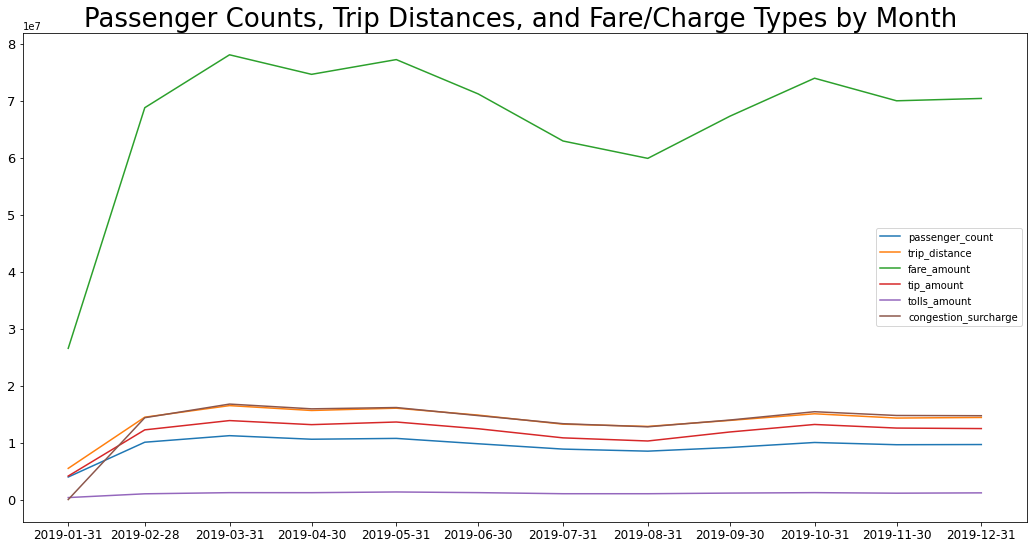

In [37]:
# 
plot_series(df_model, cols=['passenger_count','trip_distance', 'fare_amount',
                            'tip_amount', 'tolls_amount', 'congestion_surcharge'], 
            title="Passenger Counts, Trip Distances, and Fare/Charge Types by Month ", steps = 12)

IndexError: too many indices for array: array is 1-dimensional, but 7 were indexed

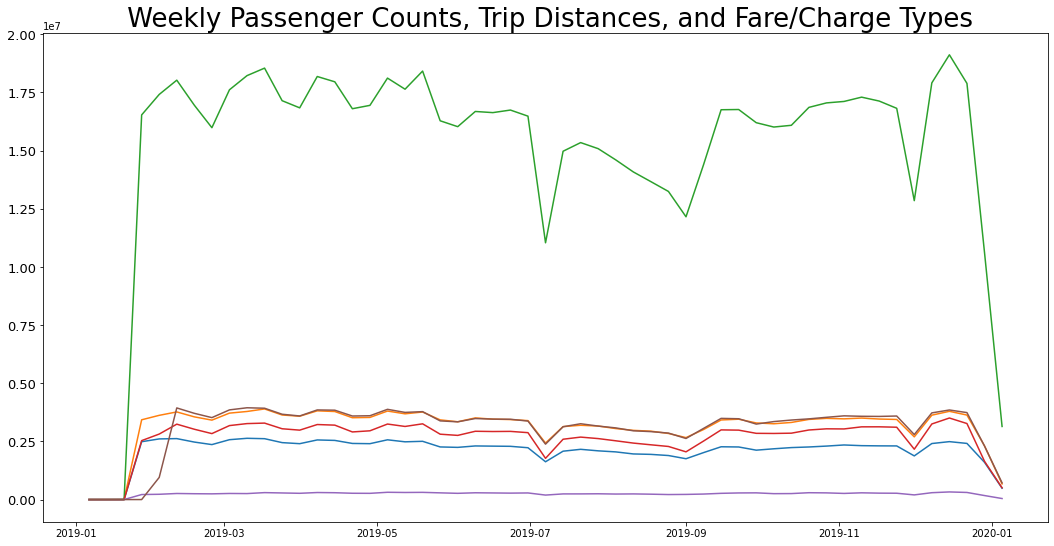

In [66]:
plot_series(df_model_week, cols=['passenger_count','trip_distance', 'fare_amount',
                            'tip_amount', 'tolls_amount', 'congestion_surcharge'], title=" Weekly Passenger Counts, Trip Distances, and Fare/Charge Types", steps = 52)


In [67]:
df_model_week.head()

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,congestion_surcharge
pickup_datetime,,,,,,
2019-01-06,10.0,13.70,70.00,13.70,0.00,0.00
2019-01-13,0.0,0.00,0.00,0.00,0.00,0.00
2019-01-20,615.0,824.30,3586.50,512.63,5.76,0.00
2019-01-27,2486744.0,3428835.62,16535363.07,2533502.69,215987.79,0.00
2019-02-03,2606921.0,3620649.44,17414977.59,2815831.86,226968.79,952152.25


In [68]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic','p-value', 'Lag Used'])
    return dfoutput

### We're using Vector AutoRegressive Time series for modeling. 
We need to confirm stationarity of the data. 

Do the ADF (Augmented Dickey Fuller) statistical Test to confirm stationarity of the time series variables. If needed, do a diff one or more times until stationarity is achieved. 

In [69]:
interpret_dftest(adfuller(df_model['passenger_count']))

Test Statistic   -2.218067
p-value           0.199754
Lag Used          4.000000
dtype: float64

In [70]:
##Not stationary

In [72]:
interpret_dftest(adfuller(df_model['passenger_count'].diff().dropna())) # 

Test Statistic   -7.612703e+00
p-value           2.233236e-11
Lag Used          0.000000e+00
dtype: float64

In [73]:
# This is now stationary

In [74]:
# Create column.

df_model['first_diff_passenger_count'] = df_model['passenger_count'].diff()

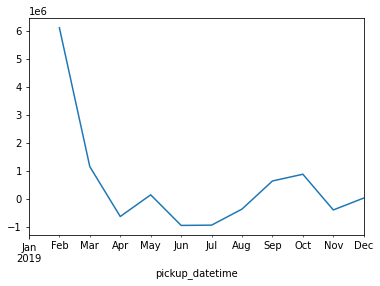

In [76]:
df_model['first_diff_passenger_count'].plot();

In [77]:
interpret_dftest(adfuller(df_model['trip_distance']))

Test Statistic   -2.682368
p-value           0.077139
Lag Used          4.000000
dtype: float64

In [80]:
interpret_dftest(adfuller(df_model['trip_distance'].diff().diff().dropna()))

Test Statistic   -3.884170
p-value           0.002154
Lag Used          1.000000
dtype: float64

In [81]:
df_model['seconf_diff_trip_distance'] = df_model['trip_distance'].diff().diff()

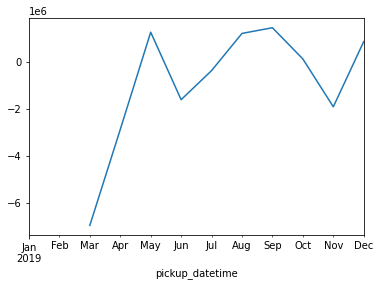

In [82]:
df_model['seconf_diff_trip_distance'].plot();

In [85]:
interpret_dftest(adfuller(df_model['fare_amount'].diff().diff().dropna()))

Test Statistic   -4.890728
p-value           0.000036
Lag Used          3.000000
dtype: float64

In [87]:
df_model['second_diff_fare_amount'] = df_model['fare_amount'].diff().diff()

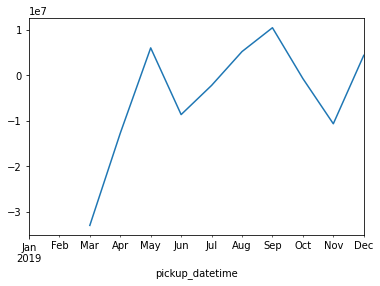

In [88]:
df_model['second_diff_fare_amount'].plot();

In [92]:
interpret_dftest(adfuller(df_model['congestion_surcharge'].diff().diff().diff().dropna()))

Test Statistic   -3.299908
p-value           0.014883
Lag Used          0.000000
dtype: float64

In [93]:
df_model['third_diff_congestion_surcharge']= df_model['congestion_surcharge'].diff().diff().diff()

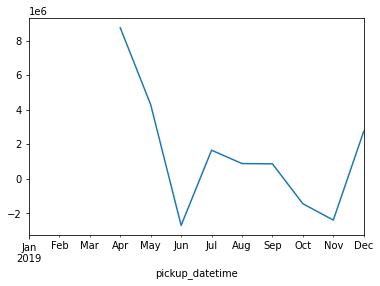

In [94]:
df_model['third_diff_congestion_surcharge'].plot();

In [110]:
interpret_dftest(adfuller(df_model['tip_amount'].diff().diff().dropna()))

Test Statistic   -9.409964e+00
p-value           5.871350e-16
Lag Used          3.000000e+00
dtype: float64

In [111]:
df_model['second_diff_tip_amount'] = df_model['tip_amount'].diff().diff()

In [112]:
interpret_dftest(adfuller(df_model['tolls_amount'])) #stationary!

Test Statistic   -3.551139
p-value           0.006767
Lag Used          4.000000
dtype: float64

In [139]:
df_model.head(20)

,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,congestion_surcharge,first_diff_passenger_count,seconf_diff_trip_distance,second_diff_fare_amount,third_diff_congestion_surcharge,second_diff_tip_amount
pickup_datetime,,,,,,,,,,,
2019-01-31,3955569.0,5471406.04,26528951.81,4125663.60,348814.05,77.50,NaN,NaN,NaN,NaN,NaN
2019-02-28,10058039.0,14451523.44,68738918.35,12227551.97,1009876.57,14358553.50,6102470.0,NaN,NaN,NaN,NaN
2019-03-31,11208384.0,16478687.12,78019315.61,13855553.56,1212346.31,16748701.75,1150345.0,-6952953.72,-32929569.28,NaN,-6473886.78
2019-04-30,10582507.0,15626694.27,74591498.93,13142489.02,1208845.75,15915088.75,-625877.0,-2879156.53,-12708213.94,8744566.50,-2341066.13
2019-05-31,10729516.0,16027499.60,77178428.04,13603797.95,1331010.12,16143968.50,147009.0,1252798.18,6014745.79,4286254.00,1174373.47
2019-06-30,9786364.0,14814816.93,71148468.01,12421400.39,1215573.59,14725184.25,-943152.0,-1613488.00,-8616889.14,-2710156.75,-1643706.49
2019-07-31,8852253.0,13223008.28,62897370.97,10822502.43,1024679.88,13306609.75,-934111.0,-379125.98,-2221137.01,1647873.75,-416500.40
2019-08-31,8491382.0,12832164.60,59851307.41,10274345.21,1023604.86,12761738.25,-360871.0,1200964.97,5205033.48,873493.25,1050740.74
2019-09-30,9131961.0,13882780.49,67240422.52,11853874.87,1135736.47,13948065.25,640579.0,1441459.57,10435178.67,857495.50,2127686.88


Use the coefficient of correlation between two values in a time series, the autocorrelation function (ACF), to identify seasonality in our time series data. 

Use the ACF plot, a bar chart of the coefficients of correlation between a time series and lags of itself, to pick the points that are statistically significant (outside the blue shaded Confidence Interval region). 

Use the Partial autocorrelation (PACF), a statistical measure that captures the correlation between two variables after controlling for the effects of other variables, to confirm the statistically significant lags.


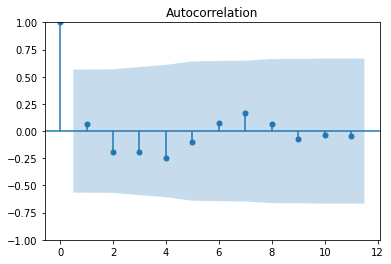

In [133]:
plot_acf(df_model['passenger_count'], lags=11);

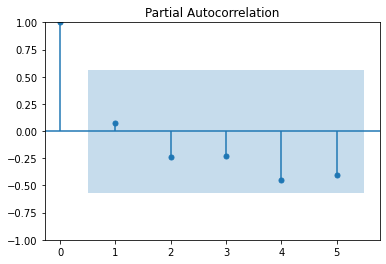

In [136]:
# Generate the PACF plot 

plot_pacf( df_model['passenger_count'], lags=5);

In [142]:
df_model.columns

Index(['passenger_count', 'trip_distance', 'fare_amount', 'tip_amount',
       'tolls_amount', 'congestion_surcharge', 'first_diff_passenger_count',
       'seconf_diff_trip_distance', 'second_diff_fare_amount',
       'third_diff_congestion_surcharge', 'second_diff_tip_amount'],
      dtype='object')

In [145]:
# Subset our data. Use our differenced columns
df_ts = df_model[['first_diff_passenger_count',
       'seconf_diff_trip_distance', 'second_diff_fare_amount',
       'third_diff_congestion_surcharge', 'second_diff_tip_amount']]

# Let's get rid of rows containing missing values.
df_ts.dropna(inplace = True)

df_ts



,first_diff_passenger_count,seconf_diff_trip_distance,second_diff_fare_amount,third_diff_congestion_surcharge,second_diff_tip_amount
pickup_datetime,,,,,
2019-04-30,-625877.0,-2879156.53,-12708213.94,8744566.50,-2341066.13
2019-05-31,147009.0,1252798.18,6014745.79,4286254.00,1174373.47
2019-06-30,-943152.0,-1613488.00,-8616889.14,-2710156.75,-1643706.49
2019-07-31,-934111.0,-379125.98,-2221137.01,1647873.75,-416500.40
2019-08-31,-360871.0,1200964.97,5205033.48,873493.25,1050740.74
2019-09-30,640579.0,1441459.57,10435178.67,857495.50,2127686.88
2019-10-31,880660.0,114491.05,-717784.35,-1454613.00,-260312.96
2019-11-30,-391934.0,-1915894.61,-10632681.93,-2401295.00,-1950380.99
2019-12-31,32157.0,854813.30,4372048.48,2744360.00,541189.13


In [146]:
train, test = train_test_split(df_ts, shuffle=False, 
                               test_size = 0.05) # use small test size, as we can't predict far into the future
# Out of 131 rows (dropped one null), train has 124 and test has 7

In [147]:
# Instantiate a VAR model. 

model = VAR(train, dates = train.index, freq='M')

In [148]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2019-12-31 to 2019-12-31
Freq: M
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   first_diff_passenger_count       1 non-null      float64
 1   seconf_diff_trip_distance        1 non-null      float64
 2   second_diff_fare_amount          1 non-null      float64
 3   third_diff_congestion_surcharge  1 non-null      float64
 4   second_diff_tip_amount           1 non-null      float64
dtypes: float64(5)
memory usage: 48.0 bytes


In [157]:
# Fit our model and use AIC to select the value of p.

ts_model = model.fit(ic="aic")   # what "information criterion" (ic) will we use to decide what's "best?"

In [158]:

# What is the order of our autoregressive model? 
# Order ‘p’ means, up to p-lags of Y are used and they are the predictors in the equation
ts_model.k_ar

0

In [159]:
# Check out the summary of our model!
ts_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 17, May, 2022
Time:                     22:14:43
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    135.746
Nobs:                     8.00000    HQIC:                   135.361
Log likelihood:          -594.542    FPE:                8.60812e+58
AIC:                      135.696    Det(Omega_mle):     4.77689e+58
--------------------------------------------------------------------
Results for equation first_diff_passenger_count
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const   -198462.125000    243855.879202           -0.814           0.416

Results for equation seconf_diff_trip_distance
           coefficient       std. error           t-stat            prob
-----------------------

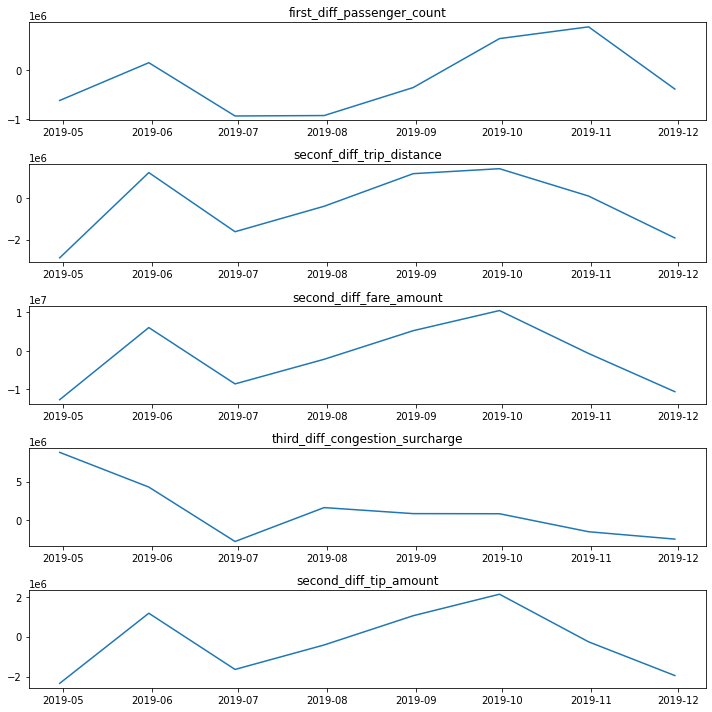

In [160]:
# Plot our training data.
ts_model.plot();
plt.tight_layout()

In [165]:
# Plot the forecast looking 3 steps ahead.
ts_model.plot_forecast(steps=1);


IndexError: index 0 is out of bounds for axis 0 with size 0